In [31]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, Normalizer
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from numpy.random import choice
import glob

# from annsa.template_sampling import *
from annsa.template_sampling import rebin_spectrum
from annsa.annsa import read_spectrum
from annsa.generate_uranium_templates import choose_uranium_template, generate_uenriched_spectrum


In [32]:
from annsa.annsa import read_spectrum
from scipy.interpolate import griddata

In [33]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Script for reading a Canberra Nuclear File (CNF) form GENIE2000 software.
It can be used as a stand alone script or as a module.
Optionally, it generates a text file with the relevant information read from the CNF file. The output file name is the input file plus the '.txt' extension.
Examples
--------
    >>> python read_cnf.py name_of_the_file.CNF
    ('name_of_the_file.CNF.txt' is automatically created)
References
----------
This script was made as a copy of the c program 'cnfconv' written for the same porpouse. That software can be found here: 
https://github.com/messlinger/cnfconv
All the information of the binary file encoding was taken from the file 'cnf_file_format.txt' of the above repository.
"""

import sys
import numpy as np
import time 
import struct


def read_cnf_file(filename,write_output=False):
    """
    Reads data of a Canberra Nuclear File used by the Genie2000 software.
    Parameters
    ----------
    filename : string
        Name of the file to be read.
    write_output : boolean, optional
        Indicate weather to write an output file or not.
    
    Returns
    -------
    read_dic : dictionary
        Dictionary with all the magnitudes read. Depending on the data available, the dictionaries keys may change. Some possible keys are:
        Sample id
        Channels
        Sample unit
        Sample name
        Channels data
        Energy unit
        Energy coefficients
        Left marker
        Total counts
        Number of channels
        Start time
        Counts in markers
        Right marker
        Sample type
        Sample description
        User name
        Live time
        Energy
        Real time
        Measurement mode   
        MCA type
        Data source
    Examples
    --------
        >>> from read_cnf import lee_cnf_file
        >>> read_dic = read_cnf_file('name_of_the_file.CNF')
        >>> read_dic['Live time']
    TODO
    ----
    - Markers information is not being read correctly.
    - If the CNF file are obtained in a MCA mode, the live and real time are not read correctly.
    - Additional data must be read in case of a file from MCA mode (mainly dwell time).
    """

    # Name of the output file
    out_filename = filename + '.txt'
    
    # Dictionary with all the information read
    read_dic = {} 
    with open(filename,'rb') as f:
        i = 0
        while True:
            # List of available section headers
            sec_header = 0x70 + i*0x30
            i+=1
            # Section id in header
            sec_id_header = uint32_at(f,sec_header)
            
            # End of section list
            if sec_id_header==0x00: break
           
            # Location of the begining of each sections
            sec_loc = uint32_at(f,sec_header+0x0a)
            # Known section id's:
            # Parameter section (times, energy calibration, etc)
            if sec_id_header==0x00012000:
                offs_param = sec_loc 
                read_dic.update(get_energy_calibration(f,offs_param))
                read_dic.update(get_date_time(f,offs_param))
            # String section
            elif sec_id_header==0x00012001:
                offs_str = sec_loc 
                read_dic.update(get_strings(f,offs_str))
            # Marker section
            elif sec_id_header==0x00012004:
                offs_mark = sec_loc
                read_dic.update(get_markers(f,offs_mark))
            # Channel data section
            elif sec_id_header==0x00012005:
                offs_chan = sec_loc
                read_dic.update(get_channel_data(f,offs_param,offs_chan))
            else: continue

            # For known sections: section header ir repeated in section block
            if (sec_id_header != uint32_at(f,sec_loc)):
                print('File {}: Format error\n'.format(filename))
        
    # Once the file is read, some derived magnitudes can be obtained

    # Convert channels to energy
    if set(('Channels','Energy coefficients')) <= set(read_dic):
        read_dic.update(chan_to_energy(read_dic))

    # Compute ingegration between markers 
    if set(('Channels','Left marker')) <= set(read_dic):
        read_dic.update(markers_integration(read_dic))

    print(50*'=')
    print(10*' '+'File '+str(filename)+' succesfully read!'+ 10*' ')
    print(50*'=')
     
    # If true, writes an text output file
    if write_output: write_to_file(out_filename,read_dic)

    return read_dic

##########################################################
# Definitions for reading some data types 
##########################################################

def uint8_at(f,pos):
    f.seek(pos)
    return np.fromfile(f,dtype=np.dtype('<u1'),count=1)[0]
def uint16_at(f,pos):
    f.seek(pos)
    return np.fromfile(f,dtype=np.dtype('<u2'),count=1)[0]
def uint32_at(f,pos):
    f.seek(pos)
    return np.fromfile(f,dtype=np.dtype('<u4'),count=1)[0]
def uint64_at(f,pos):
    f.seek(pos)
    return np.fromfile(f,dtype=np.dtype('<u8'),count=1)[0]
def pdp11f_at(f,pos):
    """
    Convert PDP11 32bit floating point format to
    IEE 754 single precision (32bits)
    """
    f.seek(pos)
    # Read two int16 numbers
    tmp16 = np.fromfile(f,dtype=np.dtype('<u2'),count=2)
    # Swapp positions
    mypack =  struct.pack('HH',tmp16[1],tmp16[0])
    f = struct.unpack('f',mypack)[0]/4.0
    return f
def time_at(f,pos):
    return ~uint64_at(f,pos)*1e-7
def datetime_at(f,pos):
    return uint64_at(f,pos) / 10000000 - 3506716800
def string_at(f,pos,length):
    f.seek(pos)
    # In order to avoid characters with not utf8 encoding
    return f.read(length).decode('utf8').rstrip('\00').rstrip()

###########################################################
# Definitions for locating and reading data inside the file
###########################################################

def get_strings(f,offs_str):
    """Read strings section."""
    
    sample_name = string_at(f,offs_str + 0x0030, 0x40)
    sample_id   = string_at(f,offs_str + 0x0070, 0x10)
    #sample_id   = string_at(f,offs_str + 0x0070, 0x40)
    sample_type = string_at(f,offs_str + 0x00b0, 0x10)
    sample_unit = string_at(f,offs_str + 0x00c4, 0x40)
    user_name   = string_at(f,offs_str + 0x02d6, 0x18)
    sample_desc = string_at(f,offs_str + 0x036e, 0x100)
        
    out_dic = {
               'Sample name': sample_name,
               'Sample id': sample_id,
               'Sample type': sample_type,
               'Sample unit': sample_unit,
               'User name': user_name,
               'Sample description': sample_desc
              }

    return out_dic

def get_energy_calibration(f,offs_param):
    """Read energy calibration coefficients."""
    
    offs_calib = offs_param + 0x30 + uint16_at(f, offs_param + 0x22)
    A = np.empty(4)
    A[0] = pdp11f_at(f, offs_calib + 0x44)
    A[1] = pdp11f_at(f, offs_calib + 0x48)
    A[2] = pdp11f_at(f, offs_calib + 0x4c)
    A[3] = pdp11f_at(f, offs_calib + 0x50)

    # Assuming a maximum length of 0x11 for the energy unit
    energy_unit = string_at(f,offs_calib + 0x5c,0x11)

    # MCA type
    MCA_type = string_at(f,offs_calib + 0x9c,0x10)
    
    # Data source
    data_source = string_at(f,offs_calib + 0x108,0x10)

    out_dic = { 'Energy coefficients': A,
                'Energy unit': energy_unit,
                'MCA type': MCA_type,
                'Data source': data_source
              }
    
    return out_dic

def get_channel_data(f,offs_param,offs_chan):
    """Read channel data."""
    
    # Total number of channels
    n_channels = uint8_at(f, offs_param + 0x00ba) * 256
    # Data in each channel
    f.seek(offs_chan + 0x200)
    chan_data = np.fromfile(f,dtype='<u4',count=n_channels)
    # Total counts of the channels
    total_counts = np.sum(chan_data)
    # Measurement mode
    meas_mode = string_at(f,offs_param + 0xb0,0x03)

    # Create array with the correct channel numbering
    channels = np.arange(1,n_channels+1,1)
    
    out_dic = {'Number of channels': n_channels,
               'Channels data': chan_data,
               'Channels': channels,
               'Total counts': total_counts,
               'Measurement mode': meas_mode
              }

    return out_dic

def get_date_time(f,offs_param):
    """Read date and time."""
    
    offs_times = offs_param + 0x30 + uint16_at(f,offs_param + 0x24)
    
    start_time = datetime_at(f,offs_times + 0x01)
    real_time = time_at(f,offs_times + 0x09)
    live_time = time_at(f,offs_times + 0x11)
    
    # Convert to formated date and time
    start_time_str = time.strftime('%d-%m-%Y, %H:%M:%S',time.gmtime(start_time))
        
    out_dic = { 'Real time': real_time,
                'Live time': live_time,
                'Start time': start_time_str
              }
    return out_dic

def get_markers(f,offs_mark):
    """Read left and right markers."""
    
    # TODO: not working properly
    marker_left  = uint32_at(f,offs_mark + 0x007a)
    marker_right = uint32_at(f,offs_mark + 0x008a)

  
    out_dic = {'Left marker': marker_left,
               'Right marker': marker_right,
              }

    return out_dic

def chan_to_energy(dic):
    """ Convert channels to energy using energy calibration coefficients."""

    A = dic['Energy coefficients']
    ch= dic['Channels']
    energy = A[0] + A[1]*ch + A[2]*ch*ch + A[3]*ch*ch*ch

    out_dic = {'Energy': energy}
 
    return  out_dic

def markers_integration(dic):
    # Count between left and right markers
    # TODO: check integral counts limits
    chan_data = dic['Channels data']
    l_marker = dic['Left marker']
    r_marker = dic['Right marker']
    marker_counts = np.sum(chan_data[l_marker-1:r_marker-1])
   
    out_dic = {'Counts in markers': marker_counts}

    return out_dic

###########################################################
# Format of the output text file
###########################################################

def write_to_file(filename,dic):
    """Write data to a text file."""
    
    with open(filename,'w') as f: 
        f.write('#\n')
        f.write('# Sample name: {}\n'.format(dic['Sample name']))
        f.write('\n')
        
        f.write('# Sample id: {}\n'.format(dic['Sample id']))
        f.write('# Sample type: {}\n'.format(dic['Sample type']))
        f.write('# User name: {}\n'.format(dic['User name']))
        f.write('# Sample description: {}\n'.format(dic['Sample description']))
        f.write('#\n')
        
        f.write('# Start time: {}\n'.format(dic['Start time']))
        f.write('# Real time (s): {:.3f}\n'.format(dic['Real time']))
        f.write('# Live time (s): {:.3f}\n'.format(dic['Live time']))
        f.write('#\n')
       
        f.write('# Total counts: {}\n'.format(dic['Total counts']))
        f.write('#\n')
       
        f.write('# Left marker: {}\n'.format(dic['Left marker']))
        f.write('# Right marker: {}\n'.format(dic['Right marker']))
        f.write('# Counts: {}\n'.format(dic['Counts in markers']))
        f.write('#\n')
        
        f.write('# Energy calibration coefficients (E = sum(Ai * n**i))\n')
        for j,co in enumerate(dic['Energy coefficients']):
            f.write('#    A{} = {:.6e}\n'.format(j,co))
        f.write('# Energy unit: {}\n'.format(dic['Energy unit']))
        f.write('#\n')
        
        f.write('# Channel data\n')
        f.write('#     n     energy({})     counts     rate(1/s)\n'.format(dic['Energy unit']))
        f.write('#'+50*'-'+'\n')
        for i,j,k in zip(dic['Channels'],dic['Energy'],dic['Channels data']):
            f.write('{:4d}\t{:.3e}\t{}\t{:.3e}\n'.format(i,j,k,k/dic['Live time']))



            
            

In [111]:
background_dataset = pd.read_csv('./dataset_generation/background_template_dataset.csv')
uranium_dataset = pd.read_csv('dataset_generation/uranium_templates_final_withbrem.csv')

In [112]:
sorted(set(uranium_dataset['shieldingdensity']))

[0.0, 0.22, 0.51, 1.53, 1.61, 1.82, 3.5, 4.18, 11.02, 13.16]

          File NaI_spectra_uranium/TL-NaI-NU.CNF succesfully read!          


(0, 1200)

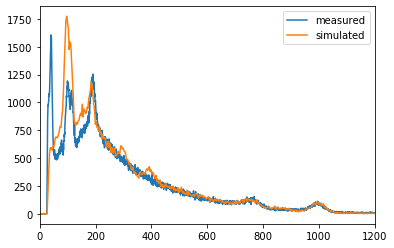

In [113]:
fileName = 'NaI_spectra_uranium/TL-NaI-NU.CNF'
 
data = read_cnf_file(fileName)

channels = data['Channels data']
energy = data['Energy']
spectrum = data['Channels data']

plt.figure()
plt.plot(energy, spectrum, label='measured')


tmp_spec = rebin_spectrum(spectrum,0,4.5,0)
# plt.figure()
# plt.plot(np.linspace(0,3e3,1024), tmp_spec)


# Simulate uranium
uranium_template = uranium_template = choose_uranium_template(
        uranium_dataset,
        sourcedist=sorted(set(uranium_dataset['sourcedist']))[2],
        sourceheight=sorted(set(uranium_dataset['sourceheight']))[0],
        shieldingdensity = sorted(set(uranium_dataset['shieldingdensity']))[6],
        fwhm=7.0,
    )

spectrum = generate_uenriched_spectrum(
                uranium_template,
                background_dataset,
                enrichment_level=0.007,
                integration_time=100,
                background_cps=200,
                calibration=[0, 1.0, 0],
                source_background_ratio=5,
    )
plt.plot(np.linspace(0,3e3,1024), spectrum, label='simulated')
plt.legend()

plt.xlim([0, 1200])


## 27 % Enriched

          File NaI_spectra_uranium/UISO-27.CNF succesfully read!          


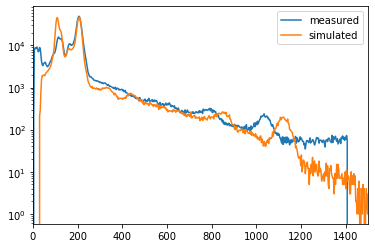

In [115]:
fileName = 'NaI_spectra_uranium/UISO-27.CNF'
# fileName = 'NaI_spectra_uranium/UISO-91_HEU.CNF'
    
data = read_cnf_file(fileName)

channels = data['Channels data']
energy = data['Energy']
spectrum = data['Channels data']
live_time = data['Live time']
# plt.plot(energy, spectrum)
# plt.semilogy()


tmp_spec = rebin_spectrum(spectrum,0,4.26,0)
plt.figure()
plt.plot(np.linspace(0,3e3,1024), tmp_spec, label='measured')
plt.semilogy()



# Simulate uranium
uranium_template = uranium_template = choose_uranium_template(
        uranium_dataset,
        sourcedist=sorted(set(uranium_dataset['sourcedist']))[2],
        sourceheight=sorted(set(uranium_dataset['sourceheight']))[0],
        shieldingdensity = sorted(set(uranium_dataset['shieldingdensity']))[3],
        fwhm=7.0,
    )

spectrum = generate_uenriched_spectrum(
                uranium_template,
                background_dataset,
                enrichment_level=0.27,
                integration_time=344,
                background_cps=100,
                calibration=[0, 0.89, 0],
                source_background_ratio=30.0,
    )

plt.plot(np.linspace(0,3e3,1024), spectrum, label='simulated')
plt.xlim([0,1500])
# plt.xlim([0,300])

plt.legend()

## 91 % Enriched

          File NaI_spectra_uranium/UISO-91_HEU.CNF succesfully read!          


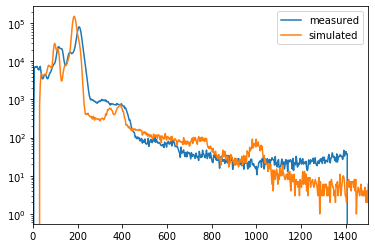

In [116]:
fileName = 'NaI_spectra_uranium/UISO-91_HEU.CNF'

data = read_cnf_file(fileName)

channels = data['Channels data']
energy = data['Energy']
spectrum = data['Channels data']
live_time = data['Live time']
# plt.plot(energy, spectrum)
# plt.semilogy()


tmp_spec = rebin_spectrum(spectrum,0,4.26,0)
plt.figure()
plt.plot(np.linspace(0,3e3,1024), tmp_spec, label='measured')
plt.semilogy()



# Simulate uranium
uranium_template = uranium_template = choose_uranium_template(
        uranium_dataset,
        sourcedist=sorted(set(uranium_dataset['sourcedist']))[1],
        sourceheight=sorted(set(uranium_dataset['sourceheight']))[0],
        shieldingdensity = sorted(set(uranium_dataset['shieldingdensity']))[2],
        fwhm=7.0,
    )

spectrum = generate_uenriched_spectrum(
                uranium_template,
                background_dataset,
                enrichment_level=0.91,
                integration_time=344,
                background_cps=100,
                calibration=[0, 1.0, 0],
                source_background_ratio=50.0,
    )

plt.plot(np.linspace(0,3e3,1024), spectrum, label='simulated')
plt.xlim([0,1500])

plt.legend()

66.6076394489696 % error - 28.378882312935918
99.99389963189904 % error - 7.520322184837673
99.76550837807461 % error - 7.274740191478079
99.96311133080869 % error - 7.487216484740515
99.999940327595 % error - 7.526817556553751
94.17765646318614 % error - 1.2662972722431478
97.8664978706632 % error - 5.232793409315256
92.84198694868905 % error - 0.16990650678597502
91.53341354918977 % error - 1.576974678290577
99.0160912800667 % error - 6.468915354910434
99.99967082486175 % error - 7.5265277686685454
98.17122156755657 % error - 5.560453298447914
98.72214203862542 % error - 6.152840901747765
99.99999960143214 % error - 7.5268812918625025
97.78157387597903 % error - 5.141477285998954
95.50128645288214 % error - 2.6895553256797142
99.31100532981812 % error - 6.786027236363557
98.91083102219012 % error - 6.355732281924862
86.26956288453377 % error - 7.237029156415308
91.11945895289821 % error - 2.022087147421281
66.12453112695003 % error - 28.89835362693546
66.31842734374982 % error - 28.6

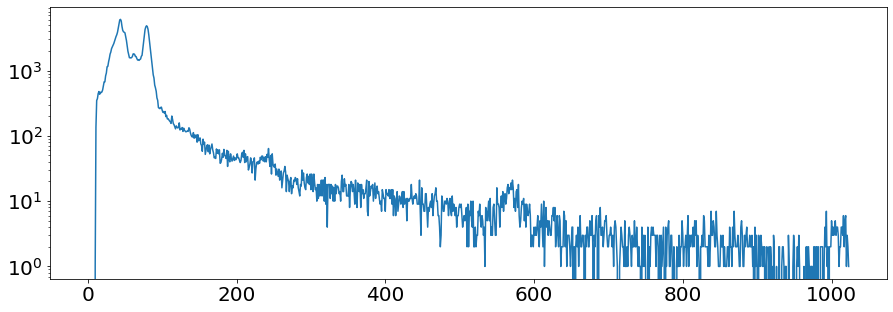

In [33]:


RF_spec = []
# for filename in glob.glob('./rocky_flats_spectra/30s_RF_0*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-740V/5s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-740V/10s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-740V/30s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-750V/5s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-750V/10s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-760V/5s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-760V/10s_TEST_number_00*.Spe'):
for filename in glob.glob('./rocky_flats_spectra/RFshells-760V/30s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-770V/5s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-770V/10s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshells-770V/30s_TEST_number_00*.Spe'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandTungsten-740V/5s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandTungsten-740V/10s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandTungsten-740V/30s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandIron-750V/5s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandIron-750V/10s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandIron-750V/30s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandIron-760V/5s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandIron-760V/10s_TEST_number_00*'):
# for filename in glob.glob('./rocky_flats_spectra/RFshellsandIron-760V/30s_TEST_number_00*'):

    RF_spec.append(read_spectrum(filename))

RF_spec_cumsum = np.cumsum(RF_spec, axis = 0)

total_spectra = 9


RF_spec_recal = np.array(RF_spec_cumsum[total_spectra])
# new_bin_positions = 4 + 0.86*np.arange(1024)# - 0.000019*np.arange(1024)**2
# new_bin_positions = 0 + 1.3*np.arange(1024)
# RF_spec_recal = griddata(np.arange(1024),
#                     np.array(RF_spec_cumsum[total_spectra]),
#                     new_bin_positions,
#                     method='linear',
#                     fill_value=0)

plt.figure(figsize=[15,5])
plt.semilogy(RF_spec_recal)

all_RF_output = []

for tmp_model in all_models:
    tmp_model_output = all_models[tmp_model].forward_pass([RF_spec_recal], training=False).numpy().flatten()[0]
    print(100*tmp_model_output, '% error -', 100*np.abs(tmp_model_output-0.93)/0.93)
    all_RF_output.append(tmp_model_output)

print(str(np.average(all_RF_output)), '+/-', str(np.var(all_RF_output)), '% error -',100*np.abs(np.average(all_RF_output)-0.93)/0.93)

